# Multilingual Data Cleaning
This notebook is for cleaning, pre-processing, and preparing the multilingual datasets.

The following languages are present:
- German,
- Arabic,
- Korean,
- Mandarin Chinese

In [38]:
# Import libraries for the cleaning:

import pandas as pd
import re
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## GERMAN 🇩🇪

In [21]:
# Start with German, CONFIG:
input_file = '/Users/hasancan/Desktop/irony_detection/other_langs_data/german_dataset.csv'
output_file = '/Users/hasancan/Desktop/irony_detection/other_langs_data/german_processed.csv'
RANDOM_SEED = 42

def process_german_data():
    print(f"Reading {input_file}...")
    df = pd.read_csv(input_file)

    # 1. Select and Rename Columns
    df = df[['transcript', 'label']].copy()
    df = df.rename(columns={'transcript': 'text'})

    # 2. Map Labels
    label_map = {'sarc': 1, 'non-sarc': 0}
    df['label'] = df['label'].map(label_map)

    # 3. Clean Text
    df['text'] = df['text'].astype(str).str.strip()

    # 4. Shuffle 
    print("Shuffling the dataset")
    df_final = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    # 5. Save
    df_final.to_csv(output_file, index=False)
    
    print("-" * 30)
    print("PROCESSING COMPLETE")
    print("-" * 30)
    print(f"Total Rows: {len(df_final)}")
    print("Class Balance:")
    print(df_final['label'].value_counts())
    print(f"\nSaved to: {output_file}")
    print("\nFirst 3 rows preview:")
    print(df_final.head(3))

if __name__ == "__main__":
    process_german_data()

Reading /Users/hasancan/Desktop/irony_detection/other_langs_data/german_dataset.csv...
Shuffling the dataset
------------------------------
PROCESSING COMPLETE
------------------------------
Total Rows: 214
Class Balance:
label
1    120
0     94
Name: count, dtype: int64

Saved to: /Users/hasancan/Desktop/irony_detection/other_langs_data/german_processed.csv

First 3 rows preview:
                                                text  label
0  Gleich mal eine persönliche Frage. Hatten Sie ...      1
1  So, immerhin kommt in diesen Tagen Bewegung in...      0
2  Das Filmchen fetzt doch, würde meine Generatio...      1


🇩🇪 Visualizing the processed German dataset: 


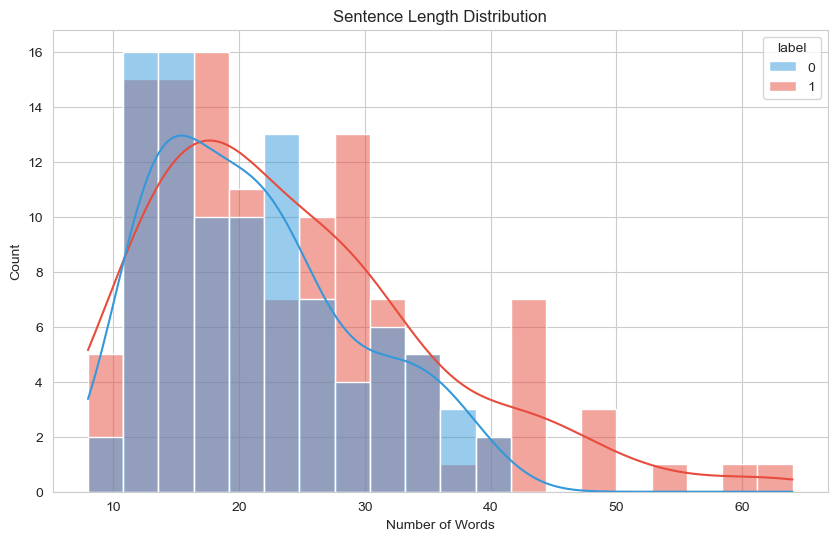

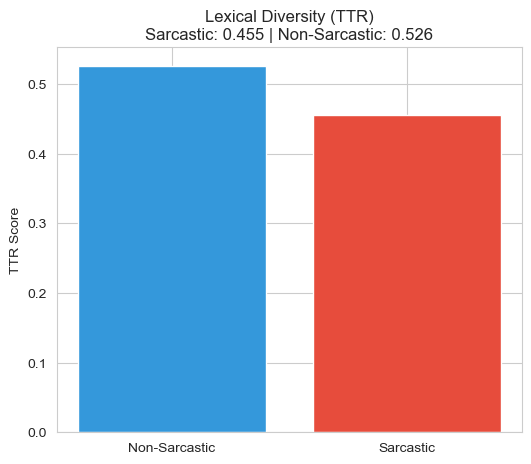

In [30]:
print("🇩🇪 Visualizing the processed German dataset: ")

# 1. Load the cleaned data
df = pd.read_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/german_processed.csv')

# 2. Setup styles
sns.set_style("whitegrid")
colors = ["#3498db", "#e74c3c"] # Blue (Non-Sarc), Red (Sarc)

# 3. Create a helper column for tokens
df['tokens'] = df['text'].astype(str).apply(lambda x: x.lower().split())
df['num_tokens'] = df['tokens'].apply(len)

# --- PLOT 1: Length Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='num_tokens', hue='label', kde=True, palette=colors, bins=20)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.show()

# --- PLOT 2: Type-Token Ratio ---
def get_ttr(subset):
    all_words = [w for sublist in subset['tokens'] for w in sublist]
    return len(set(all_words)) / len(all_words) if all_words else 0

ttr_0 = get_ttr(df[df['label']==0])
ttr_1 = get_ttr(df[df['label']==1])

plt.figure(figsize=(6, 5))
plt.bar(['Non-Sarcastic', 'Sarcastic'], [ttr_0, ttr_1], color=colors)
plt.title(f'Lexical Diversity (TTR)\nSarcastic: {ttr_1:.3f} | Non-Sarcastic: {ttr_0:.3f}')
plt.ylabel('TTR Score')
plt.show()

## ARABIC 🇸🇦

In [32]:
# CONFIGURATION
# ------------------------------------------------------
# Make sure both files are in this folder
TRAIN_FILE = '/Users/hasancan/Desktop/irony_detection/other_langs_data/arabic_train.csv'
TEST_FILE  = '/Users/hasancan/Desktop/irony_detection/other_langs_data/arabic_test.csv'
OUTPUT_FILE = '/Users/hasancan/Desktop/irony_detection/other_langs_data/arabic_processed.csv'
RANDOM_SEED = 42

# I am using both train and test files together to process because I want to clean and merge them.
# I will balance the dataset to have equal numbers of sarcastic vs literal examples so that it could be useful for our LLM experiment later.

def clean_arabic_text(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Normalize URLs -> "http"
    text = re.sub(r'http\S+|www\.\S+', 'http', text)
    
    # 2. Normalize Usernames -> "@user"
    # Matches @ followed by word characters (alphanumeric + underscore)
    text = re.sub(r'@\w+', '@user', text)
    
    # 3. Remove "RT" (Retweet marker) if it exists at the start
    text = re.sub(r'^RT\s+', '', text)
    
    # 4. Remove Emojis (Unicode ranges)
    # This regex covers most common emoji blocks
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    
    # 5. Collapse weird separators (tabs, newlines, multiple spaces)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. Strip leading/trailing punctuation (keeping hashtags # safe inside)
    # We remove punctuation ONLY from the very start or very end of the string
    # We do NOT remove punctuation in the middle (like "Hello!")
    text = text.strip(string.punctuation + " ")
    
    return text

def process_arabic():
    print("LOADING DATASETS...")
    
    dfs = []
    # Try loading Train
    try:
        df_train = pd.read_csv(TRAIN_FILE)
        dfs.append(df_train)
        print(f"✅ Loaded Train: {len(df_train)} rows")
    except FileNotFoundError:
        print(f"❌ Could not find {TRAIN_FILE}")

    # Try loading Test
    try:
        df_test = pd.read_csv(TEST_FILE)
        dfs.append(df_test)
        print(f"✅ Loaded Test:  {len(df_test)} rows")
    except FileNotFoundError:
        print(f"❌ Could not find {TEST_FILE}")

    if not dfs:
        print("No data found. Exiting.")
        return

    # 1. Merge
    df = pd.concat(dfs, ignore_index=True)
    print(f"Merged Total: {len(df)} rows")

    # 2. Rename Columns
    # We want 'tweet' -> 'text' and 'sarcasm' -> 'label'
    df = df.rename(columns={'tweet': 'text', 'sarcasm': 'label'})
    df = df[['text', 'label']] # Keep only what we need

    # 3. Clean Text
    print("Cleaning text (Normalizing URLs, Handles, Removing Emojis)...")
    df['text'] = df['text'].apply(clean_arabic_text)
    
    # Drop empty rows that might have resulted from cleaning
    df = df[df['text'] != ""]

    # 4. Balance (Stratify)
    # 0 = Not Sarcastic, 1 = Sarcastic
    sarcastic = df[df['label'] == 1]
    literal = df[df['label'] == 0]
    
    print(f"\nInitial Counts -> Sarcastic: {len(sarcastic)} | Literal: {len(literal)}")
    
    # Find the limit (Lowest common count)
    min_count = min(len(sarcastic), len(literal))
    print(f"Balancing to {min_count} per class...")
    
    sarc_balanced = sarcastic.sample(n=min_count, random_state=RANDOM_SEED)
    lit_balanced = literal.sample(n=min_count, random_state=RANDOM_SEED)
    
    # 5. Finalize
    df_final = pd.concat([sarc_balanced, lit_balanced])
    df_final = df_final.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    # Save
    df_final.to_csv(OUTPUT_FILE, index=False)
    print(f"\n✅ Saved {OUTPUT_FILE} with {len(df_final)} rows.")
    print(df_final.head())

if __name__ == "__main__":
    process_arabic()

LOADING DATASETS...
✅ Loaded Train: 8437 rows
✅ Loaded Test:  2110 rows
Merged Total: 10547 rows
Cleaning text (Normalizing URLs, Handles, Removing Emojis)...

Initial Counts -> Sarcastic: 1682 | Literal: 8865
Balancing to 1682 per class...

✅ Saved /Users/hasancan/Desktop/irony_detection/other_langs_data/arabic_processed.csv with 3364 rows.
                                                text  label
0  user اليوم قضينا على جبهة النصرة على أسوار حلب...      1
1  مع اشراقة كل شمس نبدأ عملنا بروح نشيطة وهمة عا...      0
2  حسبنا الله ونعم الوكيل " #انتخبوا_العرص #بيقول...      1
3  نبض_الاخوان | #زواج_امريكا_من_مصر_باطل حشود ها...      0
4          اجل اهزوجه ميسي الكلب القم ياكلب انت وياه      1


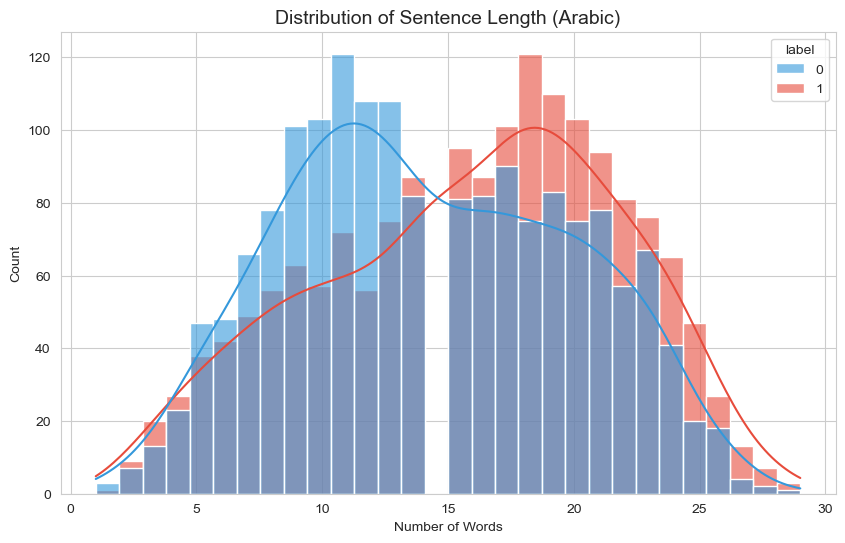

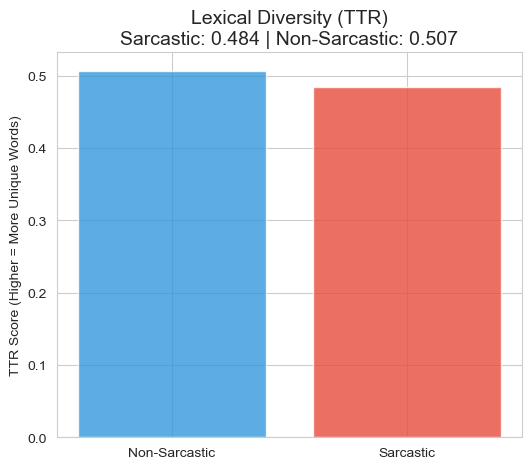

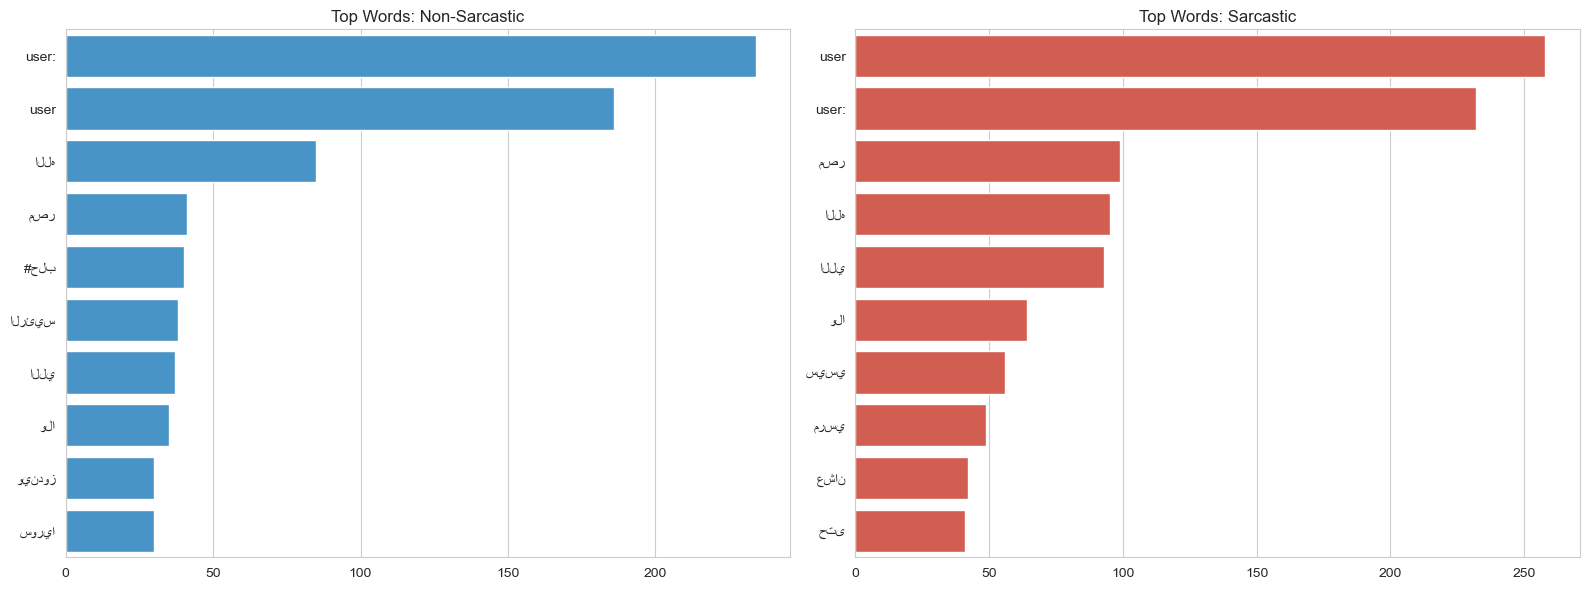

----------------------------------------
TOP WORDS TEXT REPORT
----------------------------------------
NON-SARCASTIC: ['user:', 'user', 'الله', 'مصر', '#حلب', 'الرئيس', 'اللي', 'ولا', 'ويندوز', 'سوريا']
SARCASTIC:     ['user', 'user:', 'مصر', 'الله', 'اللي', 'ولا', 'سيسي', 'مرسي', 'عشان', 'حتى']


In [37]:
# 1. Load the Arabic balanced dataset
df = pd.read_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/arabic_processed.csv')

# 2. Setup styles
sns.set_style("whitegrid")
colors = ["#3498db", "#e74c3c"] # Blue (Non-Sarc), Red (Sarc)

# 3. Pre-calculation (Tokenization)
# We split by whitespace
df['tokens'] = df['text'].astype(str).apply(lambda x: x.split())
df['num_tokens'] = df['tokens'].apply(len)

# --- VISUALIZATION 1: SENTENCE LENGTH ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='num_tokens', hue='label', kde=True, palette=colors, bins=30, alpha=0.6)
plt.title('Distribution of Sentence Length (Arabic)', fontsize=14)
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# --- VISUALIZATION 2: TYPE-TOKEN RATIO (Richness) ---
def get_ttr(subset):
    all_words = [w for sublist in subset['tokens'] for w in sublist]
    return len(set(all_words)) / len(all_words) if all_words else 0

ttr_0 = get_ttr(df[df['label']==0])
ttr_1 = get_ttr(df[df['label']==1])

plt.figure(figsize=(6, 5))
bars = plt.bar(['Non-Sarcastic', 'Sarcastic'], [ttr_0, ttr_1], color=colors, alpha=0.8)
plt.title(f'Lexical Diversity (TTR)\nSarcastic: {ttr_1:.3f} | Non-Sarcastic: {ttr_0:.3f}', fontsize=14)
plt.ylabel('TTR Score (Higher = More Unique Words)')
plt.show()

# --- VISUALIZATION 3: TOP WORDS ---
# Arabic Stopwords (Hardcoded common list)
arabic_stopwords = set([
    'في', 'من', 'على', 'عن', 'ما', 'لا', 'يا', 'و', 'ان', 'هذا', 'انا', 'مع', 'لكن', 
    'هو', 'هي', 'التي', 'الذي', 'ان', 'كان', 'كانت', 'الى', 'كل', 'لو', 'او', 'بين', 
    'له', 'لها', 'فيه', 'علي', 'عنها', 'عند', 'قبل', 'بعد', 'كيف', 'متى', 'لماذا', 'هل',
    'ماذا', 'ليس', 'لن', 'لم', 'الا', 'إلى', 'أنا', 'أنت', 'أن', 'إن', 'قد'
])

def get_top_words(subset_df, n=10):
    all_words = [word for sublist in subset_df['tokens'] for word in sublist]
    # Filter: remove stopwords, short words, and our placeholders (@user, http)
    filtered = [
        w for w in all_words 
        if w not in arabic_stopwords 
        and len(w) > 2 
        and w not in ['@user', 'http']
    ]
    return Counter(filtered).most_common(n)

top_sarc = get_top_words(df[df['label'] == 1])
top_non = get_top_words(df[df['label'] == 0])

# Plotting Top Words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Non-Sarcastic
y_words_0 = [x[0] for x in top_non]
x_counts_0 = [x[1] for x in top_non]
sns.barplot(x=x_counts_0, y=y_words_0, ax=axes[0], color=colors[0])
axes[0].set_title('Top Words: Non-Sarcastic')

# Sarcastic
y_words_1 = [x[0] for x in top_sarc]
x_counts_1 = [x[1] for x in top_sarc]
sns.barplot(x=x_counts_1, y=y_words_1, ax=axes[1], color=colors[1])
axes[1].set_title('Top Words: Sarcastic')

plt.tight_layout()
plt.show()

# --- TEXT FALLBACK ---
# Pint the lists directly
print("-" * 40)
print("TOP WORDS TEXT REPORT")
print("-" * 40)
print(f"NON-SARCASTIC: { [w[0] for w in top_non] }")
print(f"SARCASTIC:     { [w[0] for w in top_sarc] }")

## MANDARIN CHINESE 🇨🇳 
#### (Simplified)

In [43]:
TRAIN_FILE = '/Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_train.csv'
TEST_FILE  = '/Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_test.csv'
OUTPUT_FILE = '/Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_processed.csv'
RANDOM_SEED = 42

def process_chinese():
    print("LOADING CHINESE DATASETS...")
    
    dfs = []
    
    # Safe loader function
    def read_csv_safe(filepath):
        try:
            return pd.read_csv(filepath, encoding='utf-8')
        except UnicodeDecodeError:
            print(f"⚠️ UTF-8 failed for {filepath}, trying GB18030...")
            return pd.read_csv(filepath, encoding='gb18030')

    # Load files
    for fp in [TRAIN_FILE, TEST_FILE]:
        if os.path.exists(fp):
            dfs.append(read_csv_safe(fp))
            print(f"✅ Loaded {fp}")
        else:
            print(f"❌ Missing {fp}")

    if not dfs: return

    # Merge
    df = pd.concat(dfs, ignore_index=True)
    
    # Select Columns
    df = df[['Utterance', 'Sarcasm']].copy()
    df = df.rename(columns={'Utterance': 'text', 'Sarcasm': 'label'})

    # --- FIX STARTS HERE ---
    
    # 1. Clean the label column BEFORE mapping
    # This handles " sarcastic", "None ", "Sarcastic" etc.
    df['label'] = df['label'].astype(str).str.lower().str.strip()
    
    # 2. Map Labels
    label_map = {'sarcastic': 1, 'none': 0}
    df['label'] = df['label'].map(label_map)

    # 3. Report unmapped values (Debugging)
    n_missing = df['label'].isna().sum()
    if n_missing > 0:
        print(f"⚠️ WARNING: {n_missing} rows had unknown labels and became NaN. Dropping them.")

    # 4. Clean Text
    df['text'] = df['text'].astype(str).str.strip()

    # 5. Drop NaNs (CRITICAL STEP)
    # We re-assign df to ensure the drop happens
    df = df.dropna(subset=['label', 'text'])

    # 6. Convert to Integer (Safe now because NaNs are gone)
    df['label'] = df['label'].astype(int)
    
    # --- FIX ENDS HERE ---

    # Balance (Stratify)
    sarcastic = df[df['label'] == 1]
    literal = df[df['label'] == 0]
    
    min_count = min(len(sarcastic), len(literal))
    print(f"Balancing to {min_count} per class...")
    
    sarc_balanced = sarcastic.sample(n=min_count, random_state=RANDOM_SEED)
    lit_balanced = literal.sample(n=min_count, random_state=RANDOM_SEED)
    
    df_final = pd.concat([sarc_balanced, lit_balanced])
    df_final = df_final.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    df_final.to_csv(OUTPUT_FILE, index=False)
    print(f"\n✅ Saved {OUTPUT_FILE} with {len(df_final)} rows.")
    print(df_final.head())

if __name__ == "__main__":
    process_chinese()

LOADING CHINESE DATASETS...
⚠️ UTF-8 failed for /Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_train.csv, trying GB18030...
✅ Loaded /Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_train.csv
⚠️ UTF-8 failed for /Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_test.csv, trying GB18030...
✅ Loaded /Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_test.csv
⚠️ WARNING: 1912 rows had unknown labels and became NaN. Dropping them.
Balancing to 2619 per class...

✅ Saved /Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_processed.csv with 5238 rows.
        text  label
0  您别了余好多聪明啊      0
1     小心引火烧身      1
2    你瞅你这样儿你      1
3  达康书记跟前凑是吗      1
4          哦      0


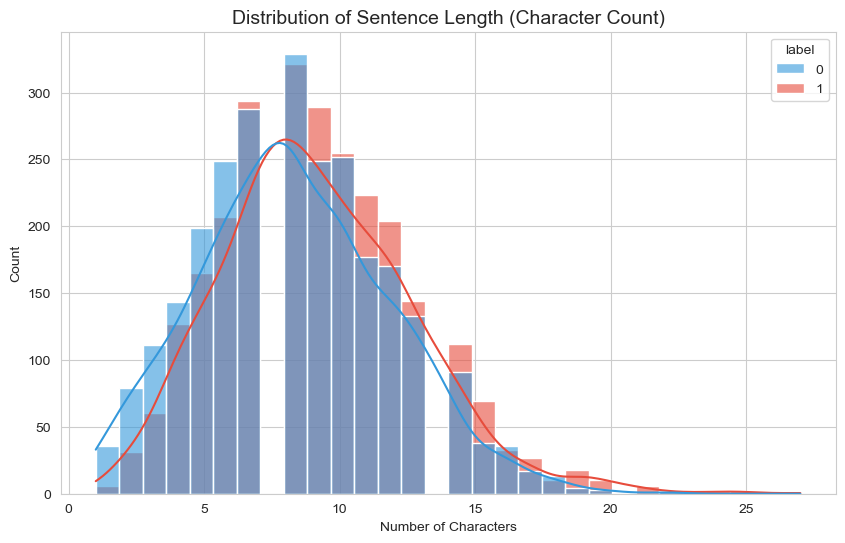

/var/folders/lh/p4vn7c1j3gz_7jnnl5ph5rzm0000gn/T/ipykernel_22941/1407861193.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette=colors)


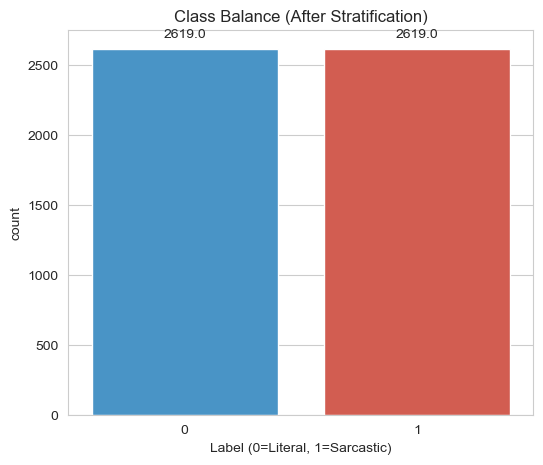

In [45]:
# 1. Load the dataset:
df = pd.read_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_processed.csv')

# 2. Setup styles
sns.set_style("whitegrid")
colors = ["#3498db", "#e74c3c"]

# 3. Calculate Length (Character Count)
# In Chinese, length is just the number of characters
df['num_chars'] = df['text'].astype(str).apply(len)

# --- VISUALIZATION 1: SENTENCE LENGTH (Chars) ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='num_chars', hue='label', kde=True, palette=colors, bins=30, alpha=0.6)
plt.title('Distribution of Sentence Length (Character Count)', fontsize=14)
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.show()

# --- VISUALIZATION 2: CLASS BALANCE ---
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='label', data=df, palette=colors)
plt.title('Class Balance (After Stratification)')
plt.xlabel('Label (0=Literal, 1=Sarcastic)')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

## KOREAN 🇰🇷

In [46]:
FILES = [
    '/Users/hasancan/Desktop/irony_detection/other_langs_data/korean_train.csv',
    '/Users/hasancan/Desktop/irony_detection/other_langs_data/korean_test.csv',
    '/Users/hasancan/Desktop/irony_detection/other_langs_data/korean_dev.csv'
]
OUTPUT_FILE = '/Users/hasancan/Desktop/irony_detection/other_langs_data/korean_processed.csv'
RANDOM_SEED = 42

def clean_korean_text(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Remove Speaker Tags "A: " or "B: " at the start
    # The regex ^ means "start of line", [AB] means A or B
    text = re.sub(r'^[AB]:\s*', '', text)
    
    # 2. Strip whitespace
    return text.strip()

def process_korean():
    print("LOADING KOREAN DATASETS...")
    
    dfs = []
    for fp in FILES:
        if os.path.exists(fp):
            try:
                # Try standard UTF-8 first
                df = pd.read_csv(fp)
            except UnicodeDecodeError:
                # Fallback to CP949 (Common for Korean CSVs)
                print(f"⚠️ UTF-8 failed for {fp}, trying CP949...")
                df = pd.read_csv(fp, encoding='cp949')
            
            dfs.append(df)
            print(f"✅ Loaded {os.path.basename(fp)} ({len(df)} rows)")
        else:
            print(f"❌ Missing {fp}")

    if not dfs:
        print("No data found. Exiting.")
        return

    # 1. Merge
    df = pd.concat(dfs, ignore_index=True)
    print(f"Merged Total: {len(df)} rows")

    # 2. Select and Rename Columns
    # We ignore 'Context' and keep only Response
    df = df[['Response', 'Sarcasm_Label']].copy()
    df = df.rename(columns={'Response': 'text', 'Sarcasm_Label': 'label'})

    # 3. Clean Text (Remove "A:", "B:")
    df['text'] = df['text'].apply(clean_korean_text)
    
    # 4. Map Labels & Clean
    # Strip whitespace from labels first just in case
    df['label'] = df['label'].astype(str).str.strip()
    
    label_map = {'Sarcasm': 1, 'Non-Sarcasm': 0}
    df['label'] = df['label'].map(label_map)

    # 5. Drop Missing/Failed rows
    df = df.dropna(subset=['label', 'text'])
    df = df[df['text'] != ""]
    
    # Force Integer
    df['label'] = df['label'].astype(int)

    # 6. Balance (Stratify)
    sarcastic = df[df['label'] == 1]
    literal = df[df['label'] == 0]
    
    print(f"\nInitial Counts -> Sarcastic: {len(sarcastic)} | Literal: {len(literal)}")
    
    # Find the limit
    min_count = min(len(sarcastic), len(literal))
    print(f"Balancing to {min_count} per class...")
    
    sarc_balanced = sarcastic.sample(n=min_count, random_state=RANDOM_SEED)
    lit_balanced = literal.sample(n=min_count, random_state=RANDOM_SEED)
    
    # 7. Finalize
    df_final = pd.concat([sarc_balanced, lit_balanced])
    df_final = df_final.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    # Save
    df_final.to_csv(OUTPUT_FILE, index=False)
    print(f"\n✅ Saved {OUTPUT_FILE} with {len(df_final)} rows.")
    
    # Preview
    print("\nFirst 5 rows:")
    print(df_final.head())

if __name__ == "__main__":
    process_korean()

LOADING KOREAN DATASETS...
✅ Loaded korean_train.csv (10466 rows)
✅ Loaded korean_test.csv (1037 rows)
✅ Loaded korean_dev.csv (1321 rows)
Merged Total: 12824 rows

Initial Counts -> Sarcastic: 7608 | Literal: 5216
Balancing to 5216 per class...

✅ Saved /Users/hasancan/Desktop/irony_detection/other_langs_data/korean_processed.csv with 10432 rows.

First 5 rows:
                                text  label
0  아, 그러니까 수학을 무너뜨리는 일이라도 하실 생각이시군요.      1
1             와, 나도 그런 꿀 잼 회사 가고 싶다!      0
2              오, 그러면 당신은 게임의 천재이군요!      1
3                현대 차나 기아차가 나을 것 같아.      0
4              우리 개들은 진짜 고기를 잘 찾는구나!      0


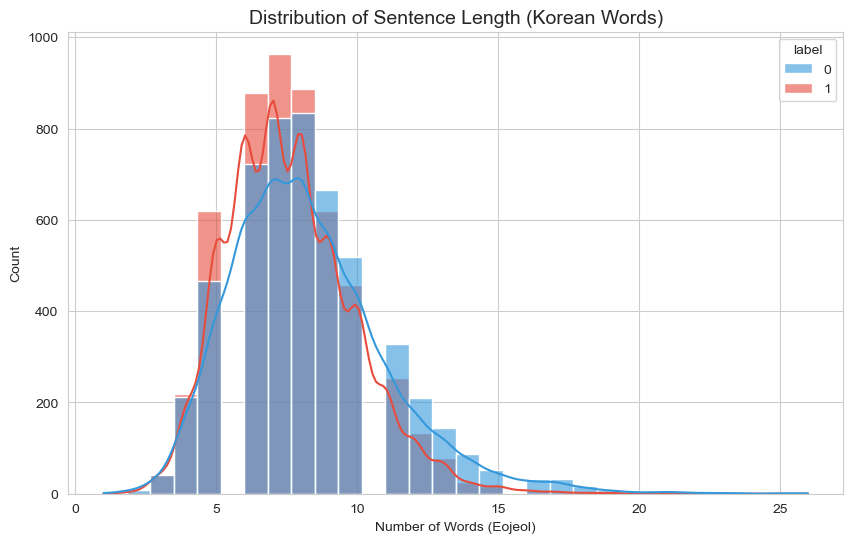

/var/folders/lh/p4vn7c1j3gz_7jnnl5ph5rzm0000gn/T/ipykernel_22941/3386641074.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette=colors)


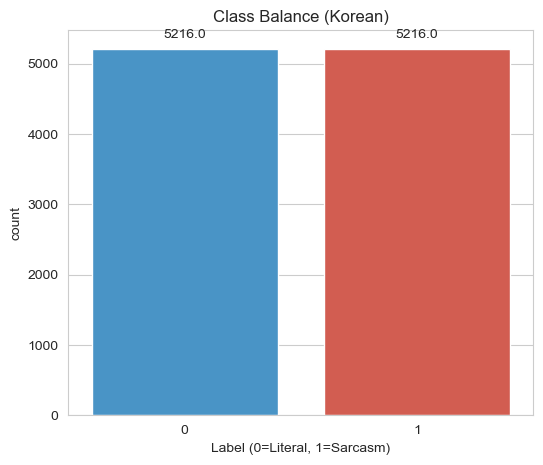

Sample Sarcastic Texts:
['아, 그러니까 수학을 무너뜨리는 일이라도 하실 생각이시군요.' '오, 그러면 당신은 게임의 천재이군요!'
 '아, 너 배 타는 거 싫어하잖아. 그럼 독도 가는 건 정말 완벽한 선택이겠네.']


In [47]:
# 1. Load Data
df = pd.read_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/korean_processed.csv')

# 2. Setup
sns.set_style("whitegrid")
colors = ["#3498db", "#e74c3c"]

# 3. Tokenize (Simple whitespace split)
df['tokens'] = df['text'].astype(str).apply(lambda x: x.split())
df['num_tokens'] = df['tokens'].apply(len)

# --- VIZ 1: SENTENCE LENGTH ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='num_tokens', hue='label', kde=True, palette=colors, bins=30, alpha=0.6)
plt.title('Distribution of Sentence Length (Korean Words)', fontsize=14)
plt.xlabel('Number of Words (Eojeol)')
plt.show()

# --- VIZ 2: CLASS BALANCE ---
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='label', data=df, palette=colors)
plt.title('Class Balance (Korean)')
plt.xlabel('Label (0=Literal, 1=Sarcasm)')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# --- CHECK DATA CONTENT ---
print("Sample Sarcastic Texts:")
print(df[df['label']==1]['text'].head(3).values)

## ENGLISH 🇺🇸

In [54]:
# I had already preprocessed it, but to check the numbers and visualize it, I do the following:

df = pd.read_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/english_processed.csv')

# Drop rows where 'text' is missing as I noticed there was a NAN value
df = df.dropna(subset=['text'])

# Verify the fix
df.info()

# save the fixed dataset
df.to_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/english_processed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 3467 entries, 0 to 3467
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3467 non-null   object
 1   label   3467 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.3+ KB


# The Final Master Code

In [59]:
import pandas as pd
import os

# CONFIGURATION
# ---------------------------------------------------------
# Ensure your file names are correct here
FILES = {
    'english': '/Users/hasancan/Desktop/irony_detection/other_langs_data/english_processed.csv',
    'german': '/Users/hasancan/Desktop/irony_detection/other_langs_data/german_processed.csv',
    'arabic': '/Users/hasancan/Desktop/irony_detection/other_langs_data/arabic_processed.csv',
    'chinese': '/Users/hasancan/Desktop/irony_detection/other_langs_data/chinese_processed.csv',
    'korean': '/Users/hasancan/Desktop/irony_detection/other_langs_data/korean_processed.csv'
}

# How many examples to hold out PER LANGUAGE for Test and Validation
# Example: 40 = 20 Sarcastic + 20 Literal per language
TEST_SIZE_PER_LANG = 40 
VAL_SIZE_PER_LANG = 40 

RANDOM_SEED = 42

def create_final_splits():
    print("LOADING ALL DATASETS...")
    data_map = {}
    
    # 1. Load Files
    for lang, fname in FILES.items():
        if os.path.exists(fname):
            df = pd.read_csv(fname)
            # Quick fix for any lingering missing values
            df = df.dropna(subset=['text', 'label'])
            df['label'] = df['label'].astype(int)
            df['language'] = lang
            data_map[lang] = df
            print(f"✅ {lang.upper():<10}: {len(df)} rows")
        else:
            print(f"❌ Missing {fname} - Stopping.")
            return

    # Containers
    test_dfs = []
    val_dfs = []
    train_pools = {} 

    print(f"\nEXTRACTING SPLITS (Test: {TEST_SIZE_PER_LANG}, Val: {VAL_SIZE_PER_LANG} per lang)...")

    for lang, df in data_map.items():
        sarc = df[df['label'] == 1]
        lit = df[df['label'] == 0]
        
        # Calculate samples needed (split equally between classes)
        n_test = TEST_SIZE_PER_LANG // 2
        n_val = VAL_SIZE_PER_LANG // 2
        
        # -- Step A: Extract Test --
        s_test = sarc.sample(n=n_test, random_state=RANDOM_SEED)
        l_test = lit.sample(n=n_test, random_state=RANDOM_SEED)
        test_dfs.append(pd.concat([s_test, l_test]))
        
        # Drop used rows
        sarc = sarc.drop(s_test.index)
        lit = lit.drop(l_test.index)
        
        # -- Step B: Extract Validation --
        s_val = sarc.sample(n=n_val, random_state=RANDOM_SEED)
        l_val = lit.sample(n=n_val, random_state=RANDOM_SEED)
        val_dfs.append(pd.concat([s_val, l_val]))
        
        # Drop used rows
        sarc = sarc.drop(s_val.index)
        lit = lit.drop(l_val.index)
        
        # -- Step C: Remaining is Training Pool --
        train_pools[lang] = pd.concat([sarc, lit])

    # 2. Save Test & Validation (The "Gold" Standards)
    master_test = pd.concat(test_dfs).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    master_val = pd.concat(val_dfs).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    master_test.to_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/final_test_gold.csv', index=False)
    master_val.to_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/final_val_gold.csv', index=False)
    
    print(f"✅ Saved 'final_test_gold.csv' ({len(master_test)} rows)")
    print(f"✅ Saved 'final_val_gold.csv'  ({len(master_val)} rows)")

    # ---------------------------------------------------------
    # 3. Create TRAIN Sets
    # ---------------------------------------------------------
    
    # A. FULL (Max Data)
    # ------------------
    all_train = pd.concat(train_pools.values())
    train_full = all_train.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    train_full.to_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/train_full.csv', index=False)
    print(f"\n✅ Saved 'train_full.csv' ({len(train_full)} rows)")
    print("   (Includes all remaining data from all languages)")

    # B. BALANCED (Fair Fight)
    # ------------------------
    # Find the language with the FEWEST remaining training rows
    min_len = min([len(df) for df in train_pools.values()])
    print(f"\nCREATING BALANCED TRAIN SET (Downsampling to {min_len} per lang)...")
    
    balanced_dfs = []
    for lang, df in train_pools.items():
        # Sample down to match the smallest language
        # We try to keep 50/50 balance inside this sample if possible
        s = df[df['label'] == 1]
        l = df[df['label'] == 0]
        
        # We need min_len total, so min_len/2 per class
        n_per_class = min_len // 2
        
        # Safe sample (in case one class is slightly smaller)
        n_s = min(n_per_class, len(s))
        n_l = min(n_per_class, len(l))
        
        # If we can't perfectly balance classes, we just take random rows to hit min_len
        if n_s + n_l < min_len:
             balanced_dfs.append(df.sample(n=min_len, random_state=RANDOM_SEED))
        else:
             balanced_dfs.append(pd.concat([
                 s.sample(n=n_s, random_state=RANDOM_SEED),
                 l.sample(n=n_l, random_state=RANDOM_SEED)
             ]))

    train_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    train_balanced.to_csv('/Users/hasancan/Desktop/irony_detection/other_langs_data/train_balanced.csv', index=False)
    print(f"✅ Saved 'train_balanced.csv' ({len(train_balanced)} rows)")

if __name__ == "__main__":
    create_final_splits()

LOADING ALL DATASETS...
✅ ENGLISH   : 3467 rows
✅ GERMAN    : 214 rows
✅ ARABIC    : 3364 rows
✅ CHINESE   : 5238 rows
✅ KOREAN    : 10432 rows

EXTRACTING SPLITS (Test: 40, Val: 40 per lang)...
✅ Saved 'final_test_gold.csv' (200 rows)
✅ Saved 'final_val_gold.csv'  (200 rows)

✅ Saved 'train_full.csv' (22315 rows)
   (Includes all remaining data from all languages)

CREATING BALANCED TRAIN SET (Downsampling to 134 per lang)...
✅ Saved 'train_balanced.csv' (670 rows)
